

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

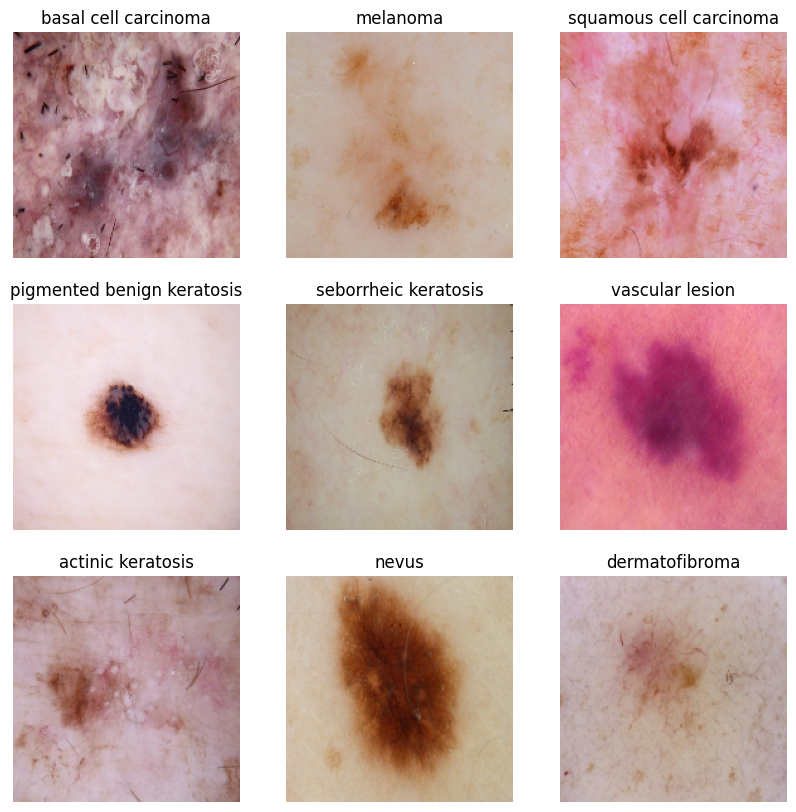

In [11]:
plt.figure(figsize=(10, 10))
covered = []
for images, labels in train_ds.take(3):
  c = 0
  for i in range(tf.shape(images)[0]):
    if labels[i] not in covered:
      ax = plt.subplot(3, 3, c + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      covered.append(labels[i])
      c+=1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a Basic CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
train_ds.element_spec[0].shape[1:]

TensorShape([180, 180, 3])

In [14]:
### Your code goes here

model = Sequential()

model.add(layers.Rescaling(scale=1./255, offset=0.0))
model.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

model.build(train_ds.element_spec[0].shape)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                        

### Train the model

In [17]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 499s 2s/step - loss: 2.8956 - accuracy: 0.3588 - val_loss: 2.6471 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 5s 96ms/step - loss: 1.2036 - accuracy: 0.5770 - val_loss: 3.5448 - val_accuracy: 0.1499
Epoch 3/30
56/56 [==============================] - 6s 99ms/step - loss: 0.7911 - accuracy: 0.7266 - val_loss: 3.9899 - val_accuracy: 0.1499
Epoch 4/30
56/56 [==============================] - 6s 104ms/step - loss: 0.4591 - accuracy: 0.8454 - val_loss: 4.0277 - val_accuracy: 0.1611
Epoch 5/30
56/56 [==============================] - 6s 100ms/step - loss: 0.2746 - accuracy: 0.9141 - val_loss: 4.1590 - val_accuracy: 0.2036
Epoch 6/30
56/56 [==============================] - 6s 99ms/step - loss: 0.1897 - accuracy: 0.9386 - val_loss: 3.9786 - val_accuracy: 0.2237
Epoch 7/30
56/56 [==============================] - 6s 99ms/step - loss: 0.1327 - accuracy: 0.9515 - val_loss: 3.0774 - val_accuracy: 0.3065
Epoch 8/30


### Visualizing training results

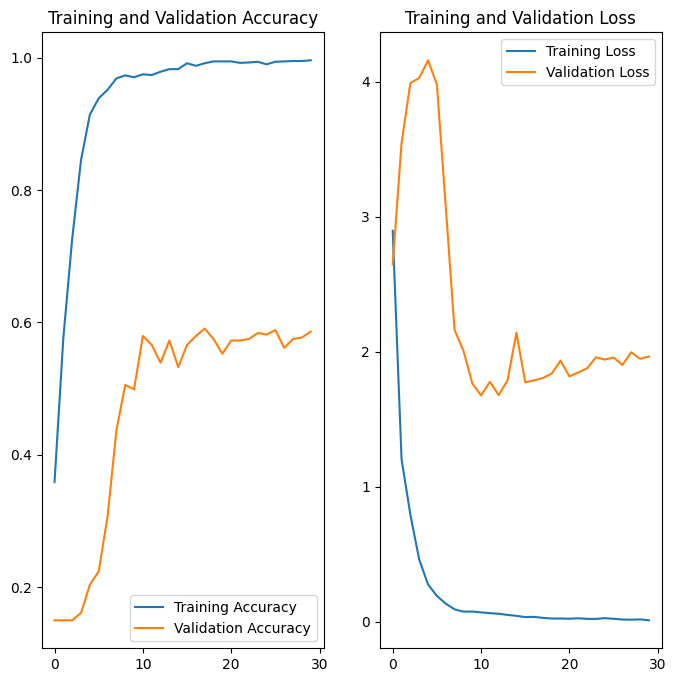

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Basic CNN:
After the model fit, It seems to be overfitting on the training data. Training accuracy seems to be very high when compared to validation accuracy

### CNN with Dropout layers added:
### Create the model, compile and train the model with dropout layers


In [15]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [16]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [17]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                        

In [18]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 340s 2s/step - loss: 3.6662 - accuracy: 0.2974 - val_loss: 2.4977 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 9s 153ms/step - loss: 1.6987 - accuracy: 0.4325 - val_loss: 2.9941 - val_accuracy: 0.1499
Epoch 3/30
56/56 [==============================] - 9s 159ms/step - loss: 1.4373 - accuracy: 0.5089 - val_loss: 3.9344 - val_accuracy: 0.1499
Epoch 4/30
56/56 [==============================] - 9s 152ms/step - loss: 1.2591 - accuracy: 0.5502 - val_loss: 3.6730 - val_accuracy: 0.1633
Epoch 5/30
56/56 [==============================] - 8s 151ms/step - loss: 1.0975 - accuracy: 0.6127 - val_loss: 2.7967 - val_accuracy: 0.2148
Epoch 6/30
56/56 [==============================] - 8s 148ms/step - loss: 0.9903 - accuracy: 0.6362 - val_loss: 3.4426 - val_accuracy: 0.2036
Epoch 7/30
56/56 [==============================] - 8s 148ms/step - loss: 0.8043 - accuracy: 0.7093 - val_loss: 2.5080 - val_accuracy: 0.3736
Epoch 8

### Visualizing the results

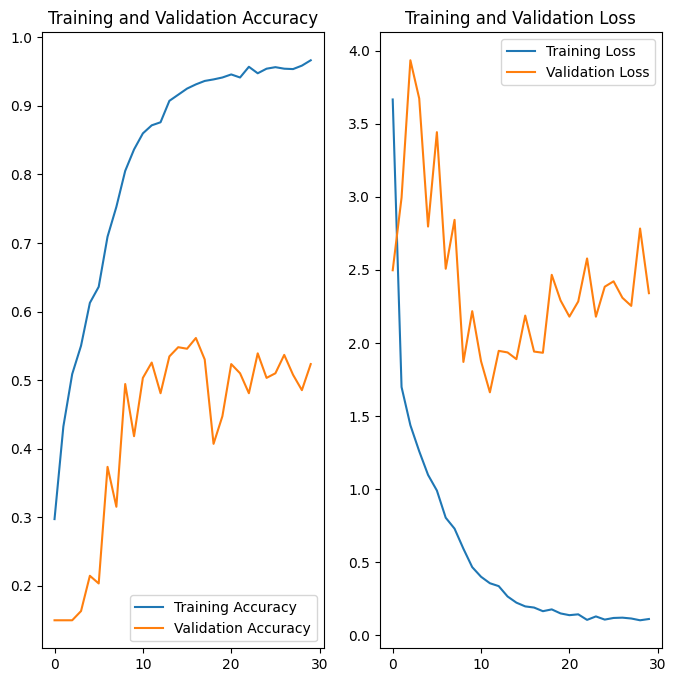

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### [Findings] CNN model with dropout layers

After the model fit, There seems to be very small improvement in the validation accuracy. **bold text**

### Add more layers in the Model:
### Create the model, compile and train the model, add more layers


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(128, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [22]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 13s 181ms/step - loss: 3.2425 - accuracy: 0.3019 - val_loss: 2.4671 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 10s 174ms/step - loss: 1.6672 - accuracy: 0.4314 - val_loss: 3.6797 - val_accuracy: 0.1499
Epoch 3/30
56/56 [==============================] - 9s 169ms/step - loss: 1.4578 - accuracy: 0.4866 - val_loss: 4.0011 - val_accuracy: 0.1499
Epoch 4/30
56/56 [==============================] - 9s 167ms/step - loss: 1.3159 - accuracy: 0.5352 - val_loss: 4.1175 - val_accuracy: 0.1499
Epoch 5/30
56/56 [==============================] - 9s 168ms/step - loss: 1.1889 - accuracy: 0.5915 - val_loss: 3.2247 - val_accuracy: 0.1991
Epoch 6/30
56/56 [==============================] - 9s 169ms/step - loss: 1.0831 - accuracy: 0.6189 - val_loss: 2.7429 - val_accuracy: 0.2170
Epoch 7/30
56/56 [==============================] - 9s 165ms/step - loss: 0.9598 - accuracy: 0.6629 - val_loss: 2.3935 - val_accuracy: 0.2573
Epoc

### Visualizing the results

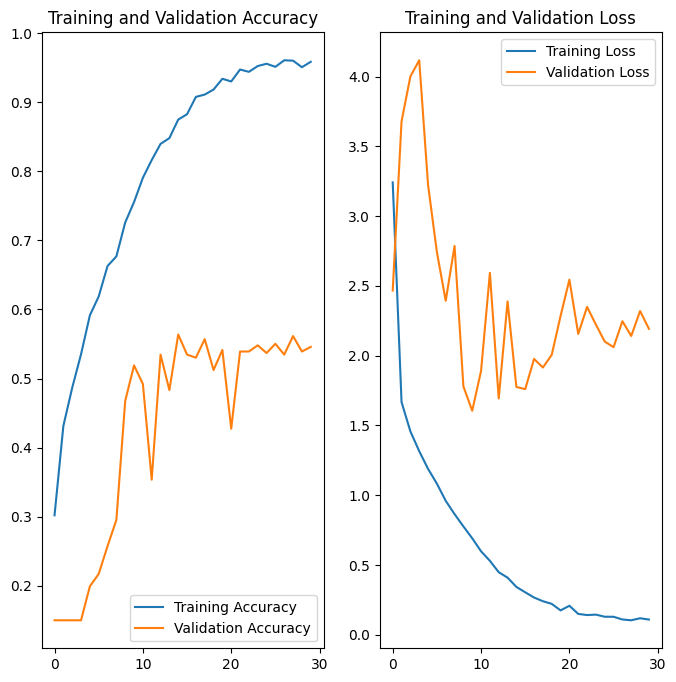

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] CNN model with more layers

After the model fit, Adding more layers doesn't seem to add much value, the validation accuracy still seems to be in the same range.



### CNN Model, Increasing the number of filters:
### Create the model, compile and train the model, increase num of filters


In [25]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(128, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [26]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 activation_24 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 batch_normalization_16 (Ba  (None, 180, 180, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 64)      36928     
                                                                 
 activation_25 (Activation)  (None, 178, 178, 64)      0         
                                                      

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 32s 408ms/step - loss: 6.6769 - accuracy: 0.2740 - val_loss: 3.2376 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 18s 316ms/step - loss: 1.9230 - accuracy: 0.4169 - val_loss: 3.6405 - val_accuracy: 0.1499
Epoch 3/30
56/56 [==============================] - 18s 321ms/step - loss: 1.4983 - accuracy: 0.4922 - val_loss: 4.1573 - val_accuracy: 0.1499
Epoch 4/30
56/56 [==============================] - 18s 323ms/step - loss: 1.2895 - accuracy: 0.5569 - val_loss: 3.0756 - val_accuracy: 0.1521
Epoch 5/30
56/56 [==============================] - 18s 316ms/step - loss: 1.0781 - accuracy: 0.6300 - val_loss: 4.0029 - val_accuracy: 0.1499
Epoch 6/30
56/56 [==============================] - 18s 317ms/step - loss: 0.9668 - accuracy: 0.6713 - val_loss: 3.7947 - val_accuracy: 0.1723
Epoch 7/30
56/56 [==============================] - 18s 314ms/step - loss: 0.8227 - accuracy: 0.7093 - val_loss: 2.8739 - val_accuracy: 0.3065

### Visualizing the results

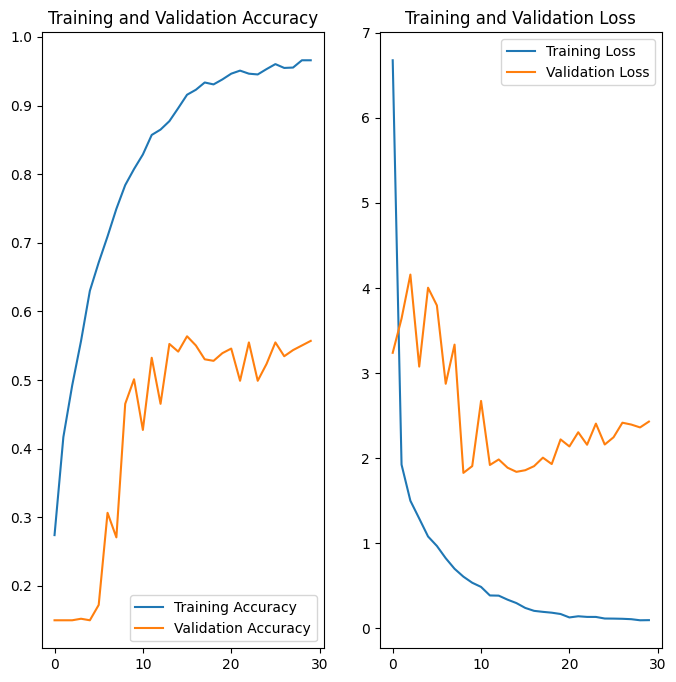

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] CNN model with increased filters

Aftet the model fit, Increasing the number of filters didn't result in any significant improvement in the validation data accuracy.

#### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

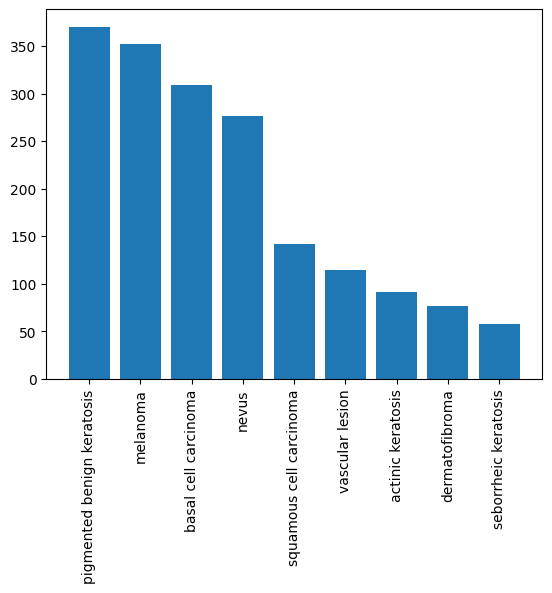

In [30]:
vals = pd.DataFrame(np.concatenate([labels.numpy() for labels in train_ds.map(lambda x, y: y)]))

plt.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)], height=vals.value_counts())
plt.xticks(rotation=90)
plt.show()

#### [findings] Class distributions:

There are classes with just 77 images and the maximum upto 400 in some classes. There is a high class imbalance.
* `seborrheic keratosis` seems to be the class with least data
* `pigmented benign keratosis` is the class with largest data.


#### Rectify the class imbalance
#### **Context:** Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [18]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [19]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin_cancer_ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785090286BF0>: 100%|██████████| 500/500 [00:23<00:00, 21.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7850902CBC40>: 100%|██████████| 500/500 [00:22<00:00, 22.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7850903FB3A0>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x785090107F40>: 100%|██████████| 500/500 [01:40<00:00,  4.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2155x1958 at 0x78509012C790>: 100%|██████████| 500/500 [01:17<00:00,  6.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7851441534C0>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x785144152650>: 100%|██████████| 500/500 [00:39<00:00, 12.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7850B2BD0F70>: 100%|██████████| 500/500 [00:19<00:00, 25.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785090347160>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [20]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [21]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [22]:
# import shutil
# for dir in glob(os.path.join(data_dir_train, '*','output')):
#   shutil.rmtree(dir)

In [23]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [24]:
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [25]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [26]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-26-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [27]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



#### Train the model on the data created using Augmentor

In [28]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [29]:
# data_dir_train="path to directory with training data + data created using augmentor"


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


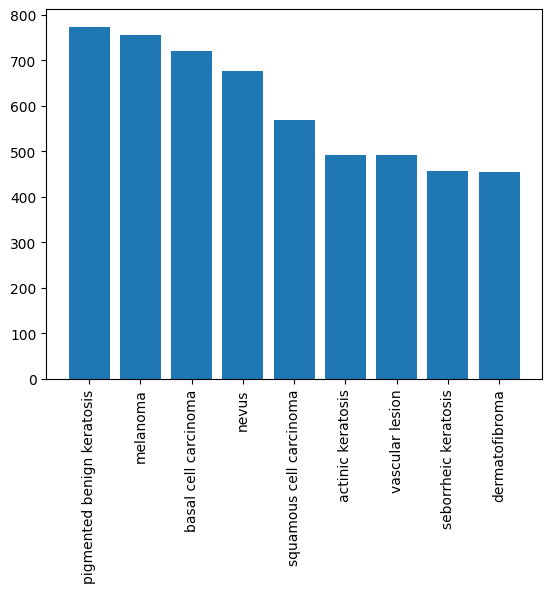

In [31]:
## Your code goes here.
vals = pd.DataFrame(np.concatenate([labels.numpy() for labels in train_ds.map(lambda x, y: y)]))
# vals.value_counts().plot.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)])

plt.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)], height=vals.value_counts())
plt.xticks(rotation=90)
plt.show()


#### Create your model

In [47]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(256))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(256))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


#### Compile your model

In [48]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_15 (Activation)  (None, 178, 178, 32)      0         
                                                      

#### **Todo:**  Train your model

In [50]:
## Your code goes here, note: train your model for 20 epochs
epochs = 40
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 [==============================] - 44s 238ms/step - loss: 2.3756 - accuracy: 0.2956 - val_loss: 6.6902 - val_accuracy: 0.1010
Epoch 2/40
169/169 [==============================] - 39s 225ms/step - loss: 1.5325 - accuracy: 0.4451 - val_loss: 2.9471 - val_accuracy: 0.1886
Epoch 3/40
169/169 [==============================] - 38s 221ms/step - loss: 1.2268 - accuracy: 0.5568 - val_loss: 2.4377 - val_accuracy: 0.3794
Epoch 4/40
169/169 [==============================] - 40s 228ms/step - loss: 0.9635 - accuracy: 0.6452 - val_loss: 2.0383 - val_accuracy: 0.4618
Epoch 5/40
169/169 [==============================] - 44s 257ms/step - loss: 0.8171 - accuracy: 0.7036 - val_loss: 1.1837 - val_accuracy: 0.6006
Epoch 6/40
169/169 [==============================] - 45s 261ms/step - loss: 0.6225 - accuracy: 0.7680 - val_loss: 0.9588 - val_accuracy: 0.6889
Epoch 7/40
169/169 [==============================] - 39s 224ms/step - loss: 0.5574 - accuracy: 0.7956 - val_loss: 0.9406 - val_ac

#### Visualize the model results

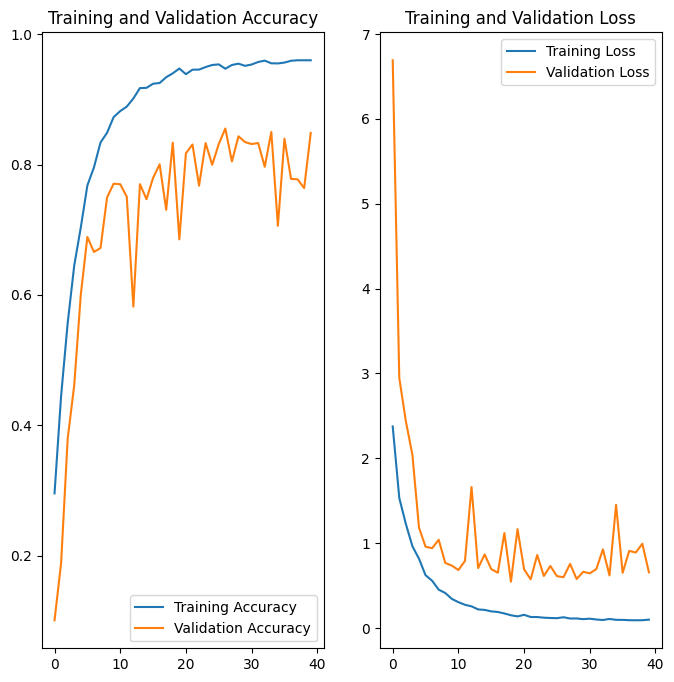

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] Final CNN model

Features included:
- Batch normalisation,
- dropout layers,
- SGD optimiser
- Image agumentation to deal with class imbalance
- Rescaling the input to 0-1


The Final model went upto ~85% in validation accuracy. Class imbalnce removal seems to have helped significantly in the increase in accuracy.

In [39]:
model1.evaluate(test_ds)

4/4 [==============================] - 5s 33ms/step - loss: 5.2416 - accuracy: 0.3729


[5.241579055786133, 0.37288135290145874]